# 画像から歩行者検出

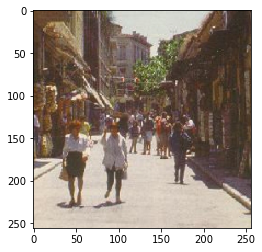

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def read_path(path):
    with open(path, encoding='utf-8') as fp:
        line = fp.readlines()
    return line

path = os.path.join(read_path('filepath')[0], 'chapter6','pedestrian_test.jpg')
img_bgr = cv2.imread(path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.show()

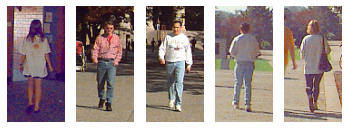

In [2]:
def read_path(path):
    with open(path, encoding='utf-8') as fp:
        line = fp.readlines()
    return line

datadir = os.path.join(read_path('filepath')[0], 'chapter6', 'pedestrians128x64')
dataset = 'pedestrians128x64'
extractdir = os.path.join(datadir, dataset)

for i in range(5):
    filename = "%s/per0010%d.ppm" % (extractdir, i)
    img = cv2.imread(filename)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i+1)
    plt.imshow(img_rgb)
    plt.axis('off')
plt.rcParams["figure.figsize"] = (20, 9)
plt.show()

In [3]:
win_size = (48, 96)
block_size = (16, 16)
block_stride = (8, 8)
cell_size = (8, 8)
num_bins = 9
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

In [4]:
import numpy as np
import random
random.seed(42)

X_pos = []
for i in random.sample(range(900), 400):
    filename = "%s/per%05d.ppm" % (extractdir, i)
    img = cv2.imread(filename)
    if img is None:
        print('Could not find image %s' % filename[-12:])
        continue
    
    X_pos.append(hog.compute(img, (64, 64)))
X_pos = np.array(X_pos, dtype=np.float32)
y_pos = np.ones(X_pos.shape[0], dtype=np.int32)
X_pos.shape, y_pos.shape

Could not find image per00000.ppm


((399, 1980, 1), (399,))

## 不正解データの切り取り

In [5]:
# ネガティブデータのディレクトリ
negdir = os.path.join(read_path('filepath')[0], 'chapter6', 'pedestrians_neg', 'pedestrians_neg')

In [6]:
img = cv2.imread(os.path.join(negdir, os.listdir(negdir)[0]))
img.shape[0], img.shape[1]

(256, 256)

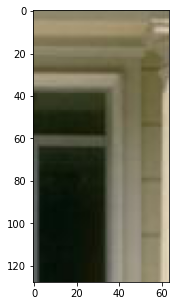

In [7]:
rand_y = random.randint(0, img.shape[0] - 128)
rand_x = random.randint(0, img.shape[1] - 64)
roi = img[rand_y:rand_y + 128, rand_x:rand_x + 64, :]
plt.rcParams["figure.figsize"] = (8, 5)
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
hroi = 128
wroi = 64
X_neg = []
for negfile in os.listdir(negdir):
    filename = os.path.join(negdir, negfile)
    img = cv2.imread(filename)
    img = cv2.resize(img, (512, 512))
    
    # 左上の隅の座標をランダムに指定して、64x128画素の関心領域(ROI:Region Of Interest)を切り出す
    for j in range(5):
        rand_y = random.randint(0, img.shape[0] - hroi)
        rand_x = random.randint(0, img.shape[1] - wroi)
        roi = img[rand_y:rand_y + hroi, rand_x:rand_x + wroi, :]
        X_neg.append(hog.compute(roi, (64, 64)))

# 特徴量を32bit浮動小数点に変換
X_neg = np.array(X_neg, dtype=np.float32)
print(f'X_neg.shape[0]: {X_neg.shape[0]}')

# ターゲットラベルを-1に設定
y_neg = -np.ones(X_neg.shape[0], dtype=np.int32)
X_neg.shape, y_neg.shape

X_neg.shape[0]: 250


((250, 1980, 1), (250,))

In [9]:
X = np.concatenate((X_pos, X_neg))
y = np.concatenate((y_pos, y_neg))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## SVMの実装

In [10]:
def train_svm(X_train, y_train):
    svm = cv2.ml.SVM_create()
    svm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)
    return svm

def score_svm(svm, X, y):
    from sklearn import metrics
    _, y_pred = svm.predict(X)
    return metrics.accuracy_score(y, y_pred)

In [11]:
svm = train_svm(X_train, y_train)
score_svm(svm, X_train, y_train)

1.0

In [12]:
score_svm(svm, X_test, y_test)

0.6461538461538462

## モデル性能向上のためのブートストラップの利用
偽陽性の学習データを学習セットに追加して再学習を行うという考え。

In [13]:
# モデルの学習と評価
score_train = []
score_test = []
for j in range(3):
    svm = train_svm(X_train, y_train)
    score_train.append(score_svm(svm, X_train, y_train))
    score_test.append(score_svm(svm, X_test, y_test))
    
    # 評価セットの偽陽性を特定
    _, y_pred = svm.predict(X_test)
    false_pos = np.logical_and((y_test.ravel() == -1), (y_pred.ravel() == 1))
    
    if not np.any(false_pos):
        print('no more false positive: done')
        break
    
    # 偽陽性のサンプルを学習セットに追加して、繰り返す
    X_train = np.concatenate((X_train, X_test[false_pos, :]), axis=0)
    y_train = np.concatenate((y_train, y_test[false_pos]), axis=0)

no more false positive: done


In [14]:
score_train, score_test

([1.0, 1.0], [0.6461538461538462, 1.0])

## より大きな画像で歩行者を検出する